In [5]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import jit

import neural_tangents as nt
from neural_tangents import stax

import tensorflow_datasets as tfds
import scipy as sp

In [7]:
# Download MNIST
dataset_name = 'MNIST'
num_classes = 10
size = 32
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024, seed=42)

In [8]:
train_ds, test_ds = tfds.load('mnist:3.*.*', split=['train[:80%]', 'train[80%:]'])

def preprocess(x):
    image, label = x['image'], x['label']
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.reshape(image, (-1,))
    return image, label

train_ds = train_ds.map(preprocess).as_numpy_iterator()
test_ds = test_ds.map(preprocess).as_numpy_iterator()

def load_x_y(ds):
    x_list, y_list = [], []
    for x, y in ds:
        x = x / np.linalg.norm(x)
        x_list.append(x)
        y_list.append(y)
    return np.stack(x_list, axis=0), np.stack(y_list, axis=0)

train_x, train_y = load_x_y(train_ds)
test_x, test_y = load_x_y(test_ds)

In [9]:
# define a RELU neural tangent kernel
_,_,kernel_fn = stax.serial(stax.Dense(1024), stax.Relu(), stax.Dense(1))
kernel_fn = jit(kernel_fn, static_argnums=(2,))

In [10]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((48000, 784), (48000,), (12000, 784), (12000,))

(array([4754., 5389., 4778., 4901., 4660., 4350., 4721., 5003., 4675.,
        4769.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

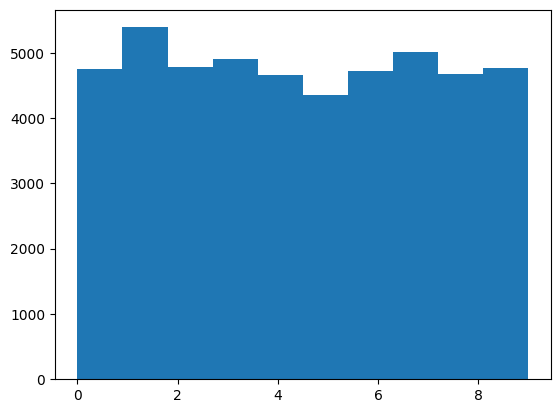

In [11]:
plt.hist(train_y)

(array([1169., 1353., 1180., 1230., 1182., 1071., 1197., 1262., 1176.,
        1180.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

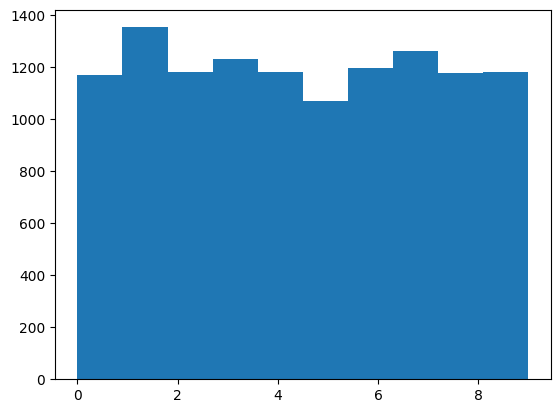

In [12]:
plt.hist(test_y)

In [13]:
# gets experimental E_g(p)
def get_learning_curve(pvals, K_train, K_test, y_train, y_test, lamb):
  num_repeats = 50
  err = np.zeros((num_repeats,len(pvals)))
  for n in range(num_repeats):
    for i, p in enumerate(pvals):
      inds = np.random.randint(0, K_train.shape[0], int(p))
      yhat = K_test[inds, :].T @ np.linalg.inv(K_train[inds, :][:, inds] + p*lamb*np.eye(int(p))) @ y_train[inds]
      err[n,i] += np.mean((yhat - y_test)**2)
  return err.mean(axis=0), err.std(axis=0)

# implicit equation for kappa
def implicit_fn_true(z,*args):
    (p, lamb, spectrum) = args
    return z - lamb - z * np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-1))

# derivative of implicit function
def f_prime_true(z,*args):
    (p, lamb, spectrum) = args
    return 1 - np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-1)) + z* np.dot(spectrum, (p*spectrum + z*np.ones(len(spectrum)) )**(-2))

# solve implicit equation with Newton's method
def solve_implicit_z(spectrum, pvals, lamb):
    sols = np.zeros(len(pvals))
    for i, p in enumerate(pvals):
        args = (p, p*lamb, spectrum)
        sols[i] = sp.optimize.root_scalar(implicit_fn_true, x0 = p * np.amax(spectrum), args = args, fprime = f_prime_true, method = 'newton').root
    return sols

# compute theory learning curve E_g(p)
def compute_theory(pvals, spectrum, teacher, lamb):
  errs = np.zeros(len(pvals))
  zvals = solve_implicit_z(spectrum, pvals, lamb)
  for i, p in enumerate(pvals):
    kappa = zvals[i]
    gamma = p * np.sum(spectrum ** 2 / (kappa + p * spectrum) ** 2)
    errs[i] = kappa ** 2 / (1 - gamma) * np.sum(spectrum * teacher ** 2 / (kappa + p * spectrum) ** 2)
  return errs / len(spectrum)

In [14]:
pvals = np.logspace(0,3.5,12)

In [15]:
def exp_2_class(a, b, lamb=1e-8):

    train_inds = [i for i in range(train_x.shape[0]) if train_y[i] == a or train_y[i] == b]
    test_inds = [i for i in range(test_x.shape[0]) if test_y[i] == a or test_y[i] == b]

    y_train = np.array([1 if yy == a else -1 for yy in train_y[train_inds]])
    y_test = np.array([1 if yy == a else -1 for yy in test_y[test_inds]])

    all_x = np.concatenate([train_x[train_inds], test_x[test_inds]], axis=0)
    all_y = np.concatenate([y_train, y_test], axis=0)
    K = kernel_fn(all_x, all_x, 'ntk')

    # k(x_train, x_train)
    K_train = K[:len(train_inds), :len(train_inds)]
    # k(x_train, x_test)
    K_test = K[:len(train_inds), len(train_inds):]
    lc, std = get_learning_curve(pvals, K_train, K_test, y_train, y_test, lamb)

    spectrum, vecs = jnp.linalg.eigh(K)
    inds_sort = np.argsort(spectrum)
    inds_sort = inds_sort[::-1]
    spectrum = spectrum[inds_sort]
    vecs = vecs[:,inds_sort]

    # plot kernel eigenspectrum spectrum
    plt.loglog(spectrum)
    plt.xlabel(r'$\rho$', fontsize=20)
    plt.ylabel(r'$\lambda_\rho$', fontsize = 20)
    plt.show()

    # get target spectrum 
    teacher = np.diag(1 / np.sqrt(spectrum)) @ vecs.T @ all_y
    theory_lc = compute_theory(pvals, spectrum, teacher, lamb)

    proj = vecs[:,0:3].T @ K

    for k,i in enumerate([a,b]):
        t = 1 if i == a else -1
        inds_i = [j for j in range(len(all_y)) if all_y[j]==t]
        plt.scatter(proj[0,inds_i], proj[1,inds_i], s=0.15, color = 'C%d' % (k+7))
        plt.scatter([],[], color = 'C%d' % (k+7), label = '%d' % i)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('K-PC 1', fontsize=20)
    plt.ylabel('K-PC 2', fontsize = 20)
    plt.tight_layout()
    plt.legend()
    plt.show()

    power = spectrum * teacher ** 2
    cumul = np.cumsum(power) / np.sum(power)
    plt.semilogx(cumul)
    plt.xlabel('k', fontsize = 20)
    plt.ylabel('C(k)', fontsize = 20)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.errorbar(pvals, 10*lc, 10*std , fmt = 'o', color='C0')
    plt.semilogx(pvals, 10*theory_lc, '--', color='C0')
    plt.xlabel(r'$P$', fontsize = 24)
    plt.ylabel(r'$E_g$', fontsize = 24)
    return (lc, std, theory_lc), (spectrum, vecs), proj, cumul, (all_x, all_y)

In [16]:
np.ones((5, 5)) @ np.diag(range(1,6))

array([[1., 2., 3., 4., 5.],
       [1., 2., 3., 4., 5.],
       [1., 2., 3., 4., 5.],
       [1., 2., 3., 4., 5.],
       [1., 2., 3., 4., 5.]])

2022-11-30 17:22:58.899256: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:492] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/pc3090/miniconda3/envs/jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3463: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


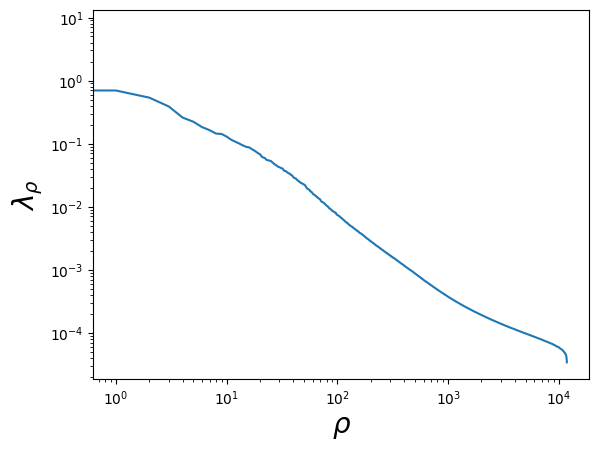

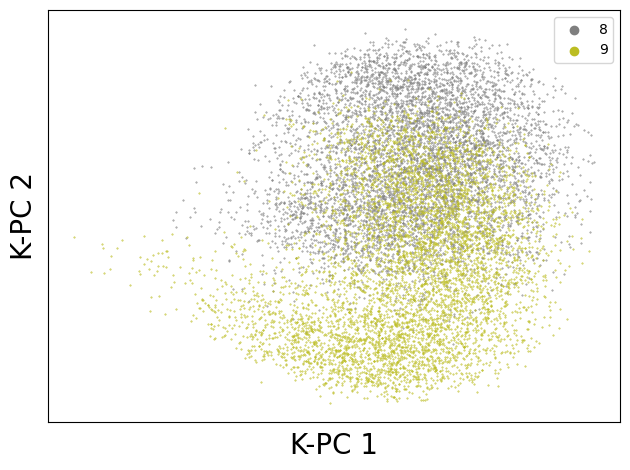

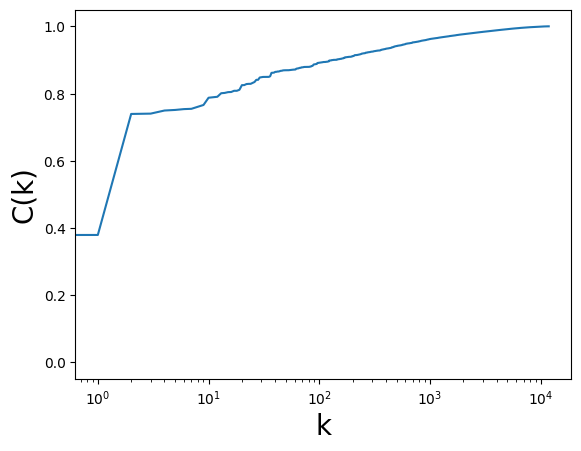

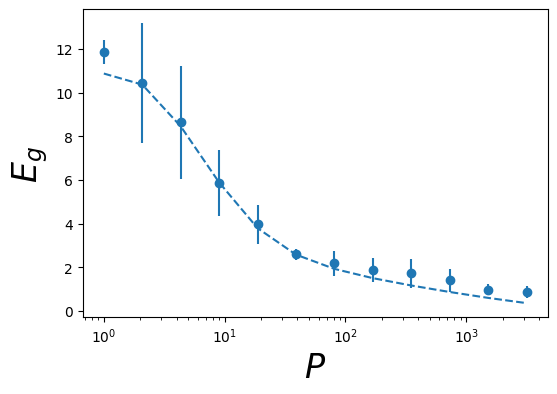

In [17]:
(lc_89, std_89, theory_lc_89), (spectrum_89, vecs_89), proj_89, cumul_89, (x_89, y_89) = exp_2_class(8, 9)

/home/pc3090/miniconda3/envs/jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3463: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


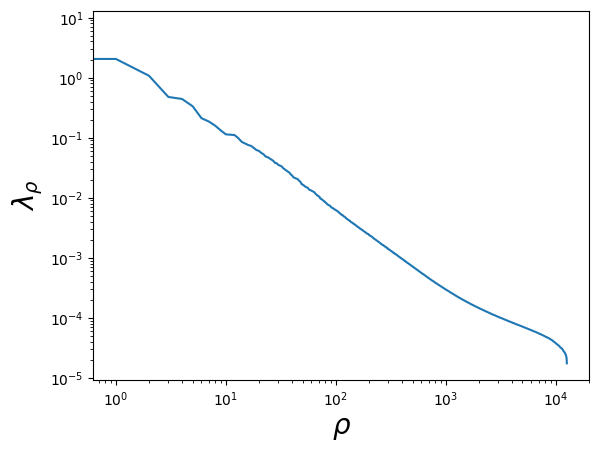

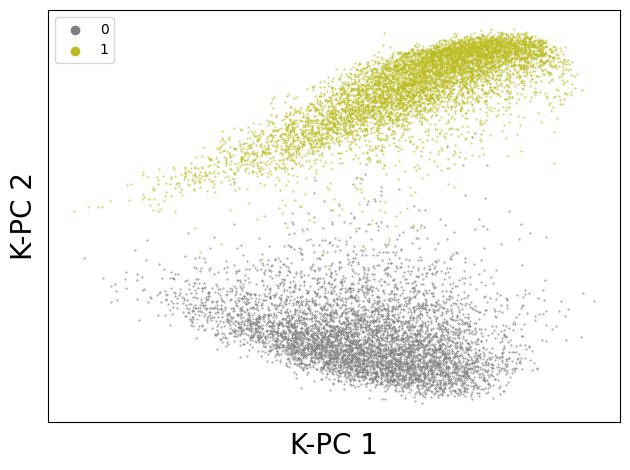

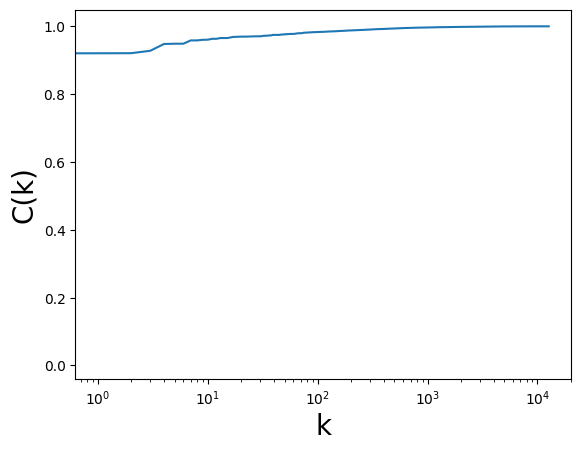

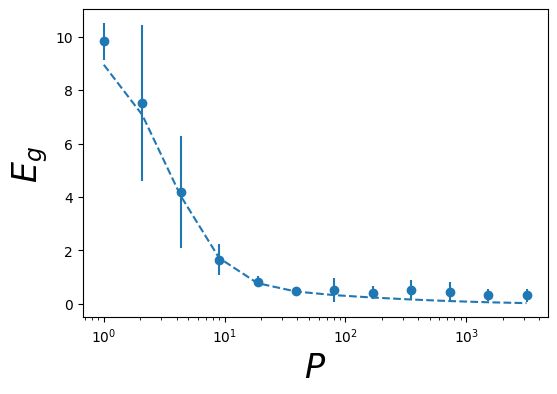

In [18]:
(lc_01, std_01, theory_lc_01), (spectrum_01, vecs_01), proj_01, cumul_01, (x_01, y_01) = exp_2_class(0, 1)

/home/pc3090/miniconda3/envs/jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3463: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


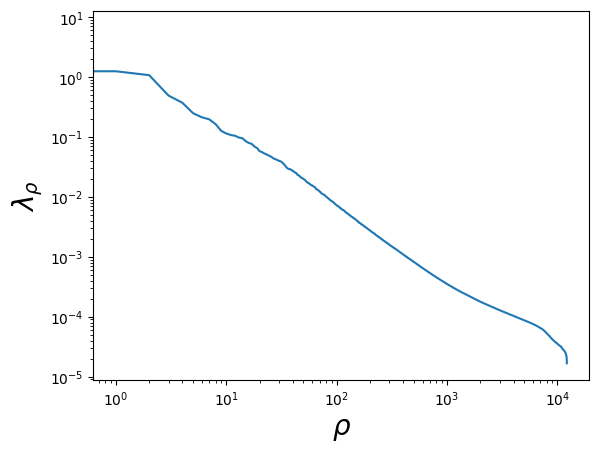

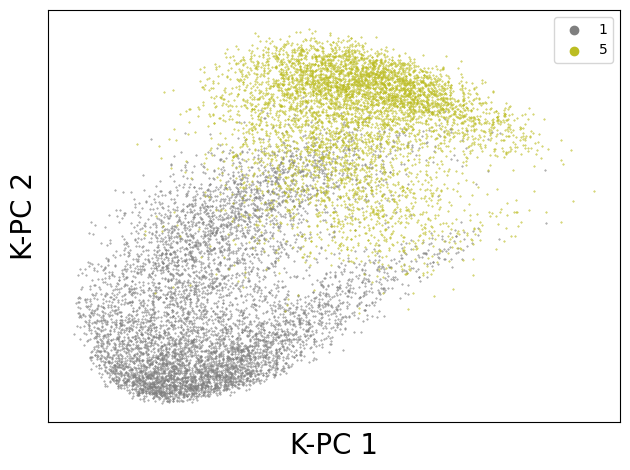

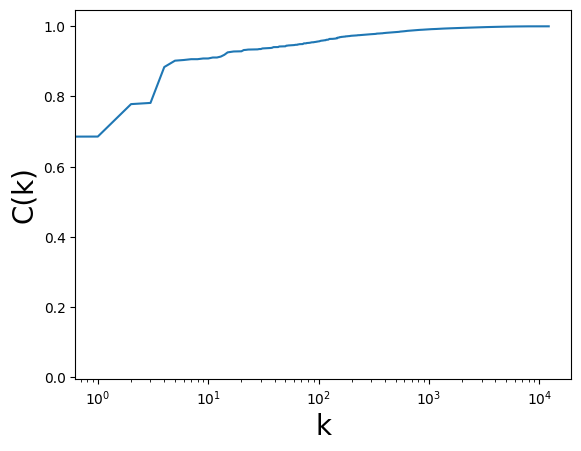

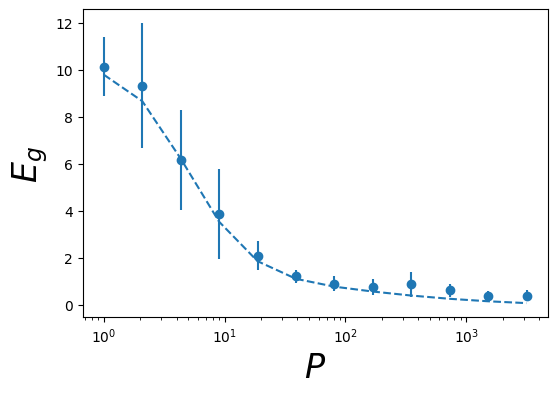

In [19]:
_ = exp_2_class(1, 5)

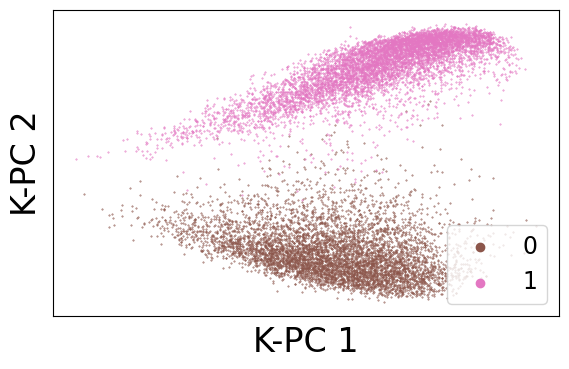

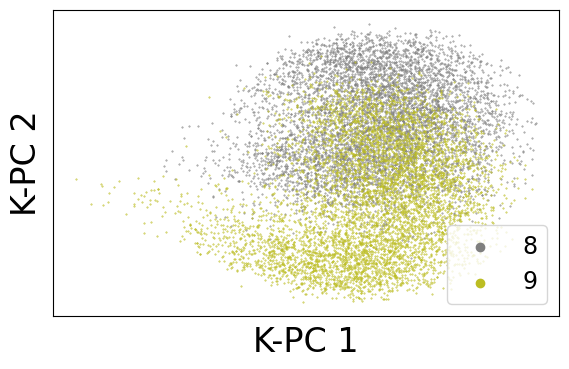

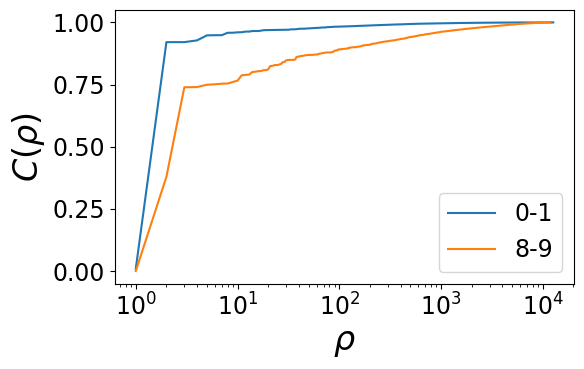

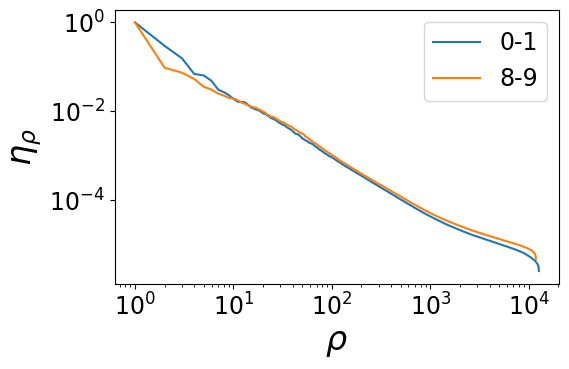

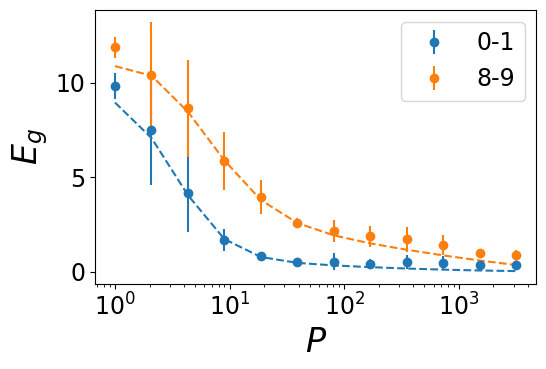

In [20]:
plt.rcParams.update({'font.size': 17})

plt.figure(figsize=(6,4))
for k,i in enumerate([0,1]):
    t = 1 if i == 0 else -1
    inds_i = [j for j in range(len(y_01)) if y_01[j]==t]
    plt.scatter(proj_01[0,inds_i], proj_01[1,inds_i], s=0.15, color = 'C%d' % (k+5))
    plt.scatter([],[], color = 'C%d' % (k+5), label = '%d' % i)
plt.xticks([])
plt.yticks([])
plt.xlabel('K-PC 1', fontsize=24)
plt.ylabel('K-PC 2', fontsize = 24)
plt.tight_layout()
plt.legend(loc = 'lower right')
plt.show()

plt.figure(figsize=(6,4))
for k,i in enumerate([8,9]):
    t = 1 if i == 8 else -1
    inds_i = [j for j in range(len(y_89)) if y_89[j]==t]
    plt.scatter(proj_89[0,inds_i], proj_89[1,inds_i], s=0.15, color = 'C%d' % (k+7))
    plt.scatter([],[], color = 'C%d' % (k+7), label = '%d' % i)
plt.xticks([])
plt.yticks([])
plt.xlabel('K-PC 1', fontsize=24)
plt.ylabel('K-PC 2', fontsize = 24)
plt.tight_layout()
plt.legend(loc = 'lower right')
plt.show()

plt.figure(figsize=(6,4))
plt.semilogx(np.linspace(1,len(cumul_01),len(cumul_01)), cumul_01, label = '0-1')
plt.semilogx(np.linspace(1,len(cumul_89),len(cumul_89)), cumul_89, label = '8-9')
plt.xlabel(r'$\rho$', fontsize = 24)
plt.ylabel(r'$C(\rho)$', fontsize =24)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.loglog(np.linspace(1,len(cumul_01),len(cumul_01)), spectrum_01/spectrum_01[0], label = '0-1')
plt.loglog(np.linspace(1,len(cumul_89),len(cumul_89)), spectrum_89/spectrum_89[0], label = '8-9')
plt.xlabel(r'$\rho$', fontsize = 24)
plt.ylabel(r'$\eta_\rho$', fontsize =24)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.errorbar(pvals, 10*lc_01, 10*std_01 , fmt = 'o', color = 'C0', label = '0-1')
plt.semilogx(pvals, 10*theory_lc_01, '--', color ='C0')
plt.errorbar(pvals, 10*lc_89, 10*std_89 , fmt = 'o', color = 'C1', label = '8-9')
plt.semilogx(pvals, 10*theory_lc_89, '--', color ='C1')
plt.xlabel(r'$P$', fontsize = 24)
plt.ylabel(r'$E_g$', fontsize = 24)
plt.legend()
plt.tight_layout()
plt.show()

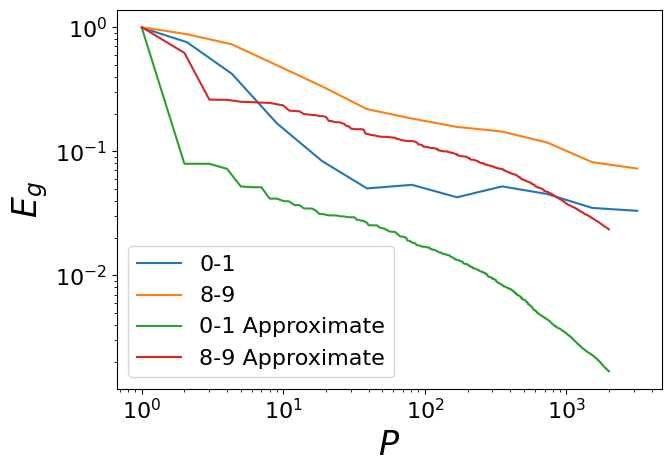

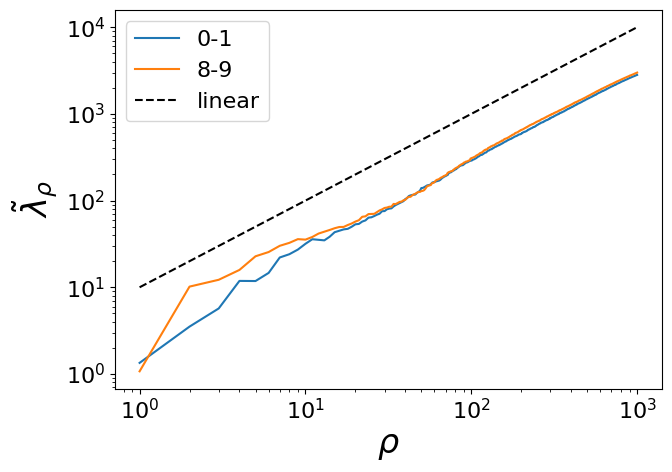

In [21]:
pmax_approx = int(10**(3.3))

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(7,5))

plt.loglog(pvals, lc_01 / lc_01[0] * (1-cumul_01[0]), label = '0-1')
plt.loglog(pvals, lc_89 / lc_89[0] * (1-cumul_89[0]), label = '8-9')
plt.loglog(np.linspace(1,pmax_approx, pmax_approx), 1-cumul_01[0:pmax_approx], label = '0-1 Approximate')
plt.loglog(np.linspace(1,pmax_approx, pmax_approx), 1-cumul_89[0:pmax_approx], label = '8-9 Approximate')
plt.xlabel(r'$P$', fontsize =24)
plt.ylabel(r'$E_g$', fontsize=24)
plt.legend()
plt.tight_layout()
plt.show()

# plot effective regularization vs rho
tail_sums_01 = (np.sum(spectrum_01) - np.cumsum(spectrum_01))/spectrum_01
tail_sums_89 = (np.sum(spectrum_89) - np.cumsum(spectrum_89))/spectrum_89

plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 16})
plt.loglog(np.linspace(1,1000,1000),tail_sums_01[0:1000], label = '0-1')
plt.loglog(np.linspace(1,1000,1000),tail_sums_89[0:1000], label = '8-9')
plt.loglog(np.linspace(1,1000,1000), 10*np.linspace(1,1000,1000), '--', color = 'black', label = 'linear')
plt.xlabel(r'$\rho$', fontsize =24)
plt.ylabel(r'$\tilde \lambda_\rho$', fontsize=24)
plt.legend()
plt.tight_layout()
plt.show()